In [1]:
#Library imports
import re
import time
import math
import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from fbprophet import Prophet
from pylab import rcParams
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
from fbprophet.plot import plot_cross_validation_metric
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

#Notebook arguments
%matplotlib inline

Importing plotly failed. Interactive plots will not work.


In [2]:
vix_prop=pd.read_pickle("vix.pickle")

# importing cleaned vix index data

In [3]:
vix_prop.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-23,26.930000,28.549999,26.540001,26.910000,26.910000,0
1,2010-06-24,27.610001,30.270000,27.530001,29.740000,29.740000,0
2,2010-06-25,29.639999,30.410000,28.070000,28.530001,28.530001,0
3,2010-06-28,29.200001,29.900000,28.469999,29.000000,29.000000,0
4,2010-06-29,31.219999,35.389999,31.219999,34.130001,34.130001,0


In [4]:
vix_prop.rename(columns={'Date': 'ds', 'Adj Close': 'y'}, inplace=True)

# renaming columns as required by Prophet

In [5]:
# Dropping columns Open, High, Low, Close and Volume 
columns_not_reqd = ['Open','High','Low','Close','Volume']
vix_prop.drop(columns=columns_not_reqd,inplace=True)

#Sanity Check
vix_prop.head()
vix_prop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518 entries, 0 to 2517
Data columns (total 2 columns):
ds    2518 non-null object
y     2518 non-null float64
dtypes: float64(1), object(1)
memory usage: 39.5+ KB


Now that we have preprocessed out data with column names as required by Prophet we are ready to start building our model

## Prophet Model Buildout ##

In [6]:
m = Prophet(daily_seasonality=True, interval_width=0.95)

# Instantiate prophet model m

In [7]:
m.fit(vix_prop)

# fit model to data

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Time to make some predictions using Prophet future_dataframe method

In [8]:
# fit and forecast future values 
future = m.make_future_dataframe(periods=10, freq='D')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
2523,2020-06-29,28.017172,16.488304,39.375336
2524,2020-06-30,27.777411,16.714522,39.923240
2525,2020-07-01,27.735194,16.868070,39.502349
2526,2020-07-02,27.645164,17.579085,38.911338
2527,2020-07-03,27.298286,16.611396,39.126469


## Visualising Forecasts using a 95% confidence interval##

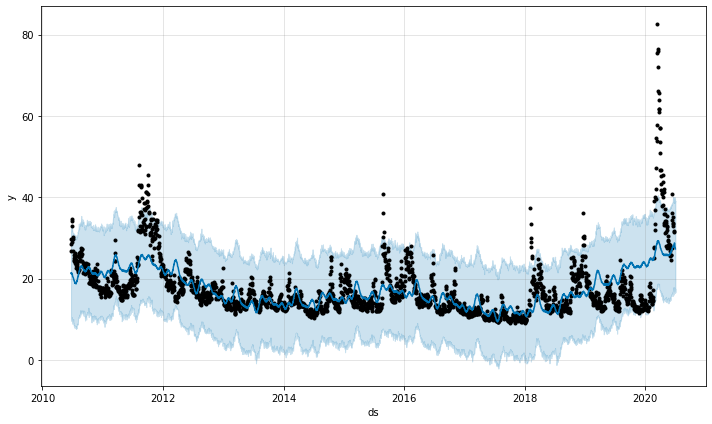

In [9]:
fig1 = m.plot(forecast)

# plotting forecast values (blue outline refers to 95% confidence interval) and actual observations (black dots represent actual values of y)

If you want to see the forecast components, we can use the Prophet.plot_components method. By default you’ll see the trend, yearly seasonality, and weekly seasonality of the time series. If you include holidays, you’ll see those here, too

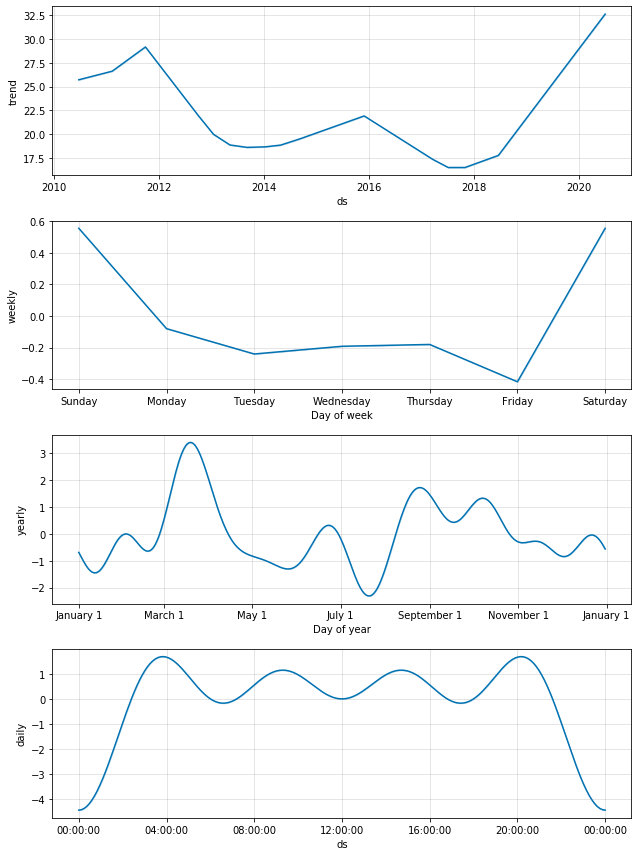

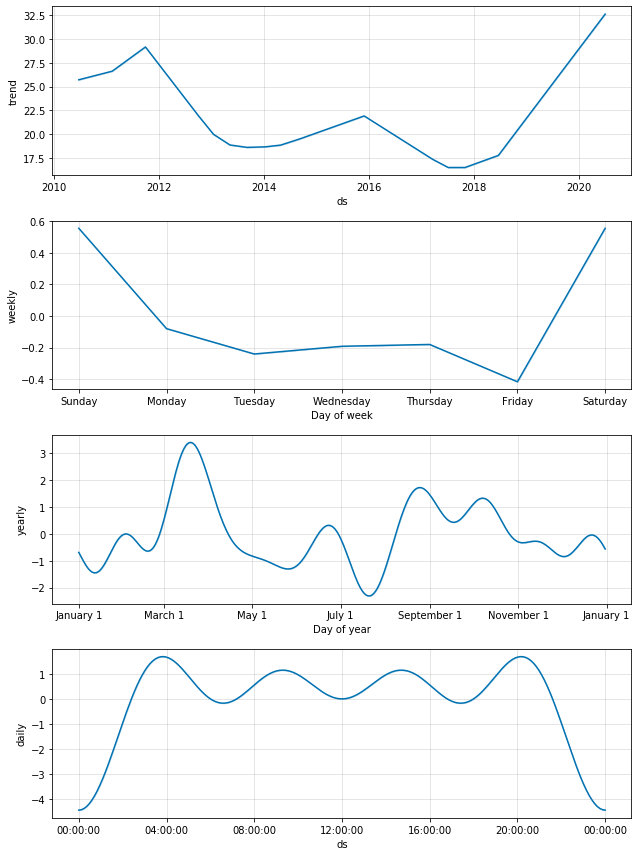

In [10]:
m.plot_components(forecast)

# plotting components of forecast like trend - weekly,yearly and daily 

Interpretation 
1. Daily - there are no inter-day trend to speak 
2. Weekly - again there is no clear trend other than to reflect the increased volatility come Monday possibly to account for the index not being operational on the weekend. Since Friday seems to the lowest volatility - it probably speaks to the fact the institutional investors incorporate all the news over the weekend into balancing their portfolios through the futures market causing Monday to be busiest day
3. Yearly - Index seems to react to Q1 & Q2 financial results more than any other quarter 
3. Overall Trend - From 2018, there is a pronunced uptick in volatility - probably to with the trade wars and slowing globalisation to possibility of increased cross-border tarriffs and reconfiguring of global supply chains 


## Identifying and plotting Changepoints in Data##

Prophet detects changepoints by first specifying a large number of potential changepoints at which the rate is allowed to change. It then puts a sparse prior on the magnitudes of the rate changes (equivalent to L1 regularization) - this essentially means that Prophet has a large number of possible places where the rate can change, but will use as few of them as possible

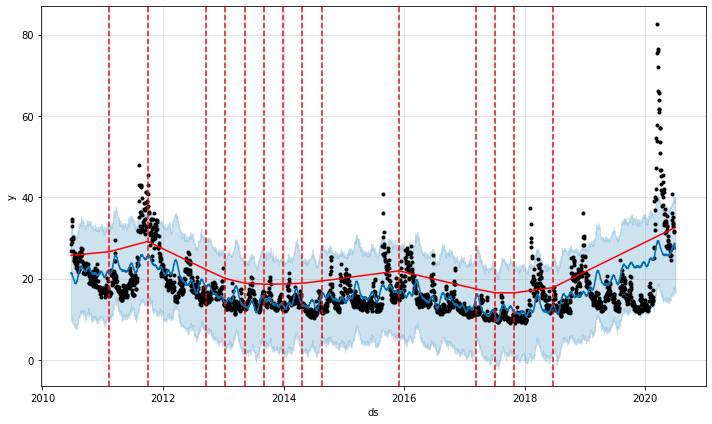

In [11]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

# plotting changepoints for dataset 

Clearly there are critical phases on change in our data as reflected by the change points with end of Q1 2018 marking the start of a increasingly volatile time for the stock markets (as we can confirm with the downturn starting Q2 last year in response to the "trade wars')

## Exploring input argument for trend in forecasts ##

If the trend changes are being overfit (too much flexibility) or underfit (not enough flexibility), you can adjust the strength of the sparse prior using the input argument changepoint_prior_scale. By default, this parameter is set to 0.5. Increasing it will make the trend more flexible. While I did explore playing around with the input argument, it was not able to achieve any meaningful difference in forecasts so left it at the default input only 

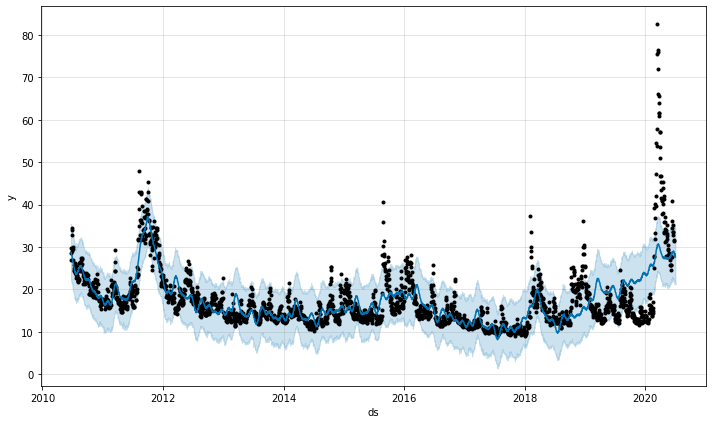

In [12]:
m = Prophet(changepoint_prior_scale=0.5, daily_seasonality=True)
forecast = m.fit(vix_prop).predict(future)
fig = m.plot(forecast)

# evaluating impact of trend using parameter changepoint_prior_scale

# Diagnostics ##

Prophet includes functionality for time series cross validation to measure forecast error using historical data. This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point. We can then compare the forecasted values to the actual values

In [13]:
# Python
df_cv = cross_validation(m, initial='750 days', period='10 days', horizon = '15 days')
df_cv.head()

# using CV function in fprophet to make predictions for 15 days using an initial training set of 2532 observations

INFO:fbprophet:Making 289 forecasts with cutoffs between 2012-07-20 00:00:00 and 2020-06-08 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-07-23,17.526555,15.019824,20.238561,18.620001,2012-07-20
1,2012-07-24,17.629866,15.079388,20.286447,20.469999,2012-07-20
2,2012-07-25,18.031889,15.269926,20.576814,19.340000,2012-07-20
3,2012-07-26,18.275851,15.683310,20.948910,17.530001,2012-07-20
4,2012-07-27,18.434901,15.755800,20.974113,16.700001,2012-07-20


In [14]:
df_p = performance_metrics(df_cv)
df_p.head()

# Generating performance metrics to evaluate forecasts

,horizon,mse,rmse,mae,mape,mdape,coverage
0,2 days,33.464712,5.784869,3.051260,0.166029,0.134227,0.720566
1,3 days,35.777343,5.981416,3.173435,0.170417,0.144351,0.697085
2,4 days,29.971039,5.474581,3.162764,0.174453,0.148988,0.662137
3,5 days,26.999869,5.196140,3.120101,0.176383,0.153125,0.645821
4,6 days,42.712718,6.535497,3.409691,0.185474,0.152867,0.646453


Clearly the model is struggling to predict with a RMSE of 1961 for a 1 day prediction horizion with RMSE increasing with an increase in prediction horizon

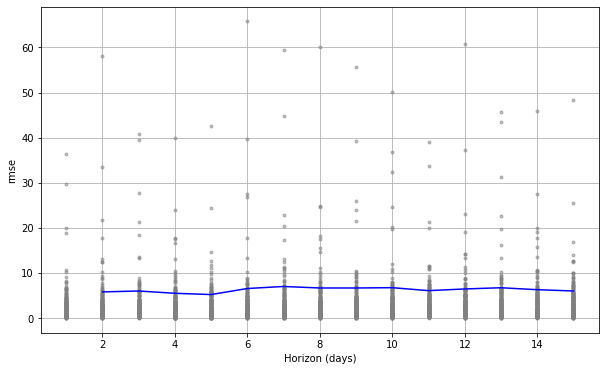

In [15]:
fig3 = plot_cross_validation_metric(df_cv, metric='rmse')

# evaluating performance using rmse 

Clearly the lowest RMSE is for the 4-5 day forecast

In conclusion, Prophet didnt have the best rmse but it easy to use and intutive to understand. Further it requires minimum pre-processing of data and can be easily modified to account for liner and non-linear trends in the data.